## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

### SOUVIK GHOSH -PGSSP -SMAI
Contact - souvik.ghosh@students.iiit.ac.in

## Provided Code

In [1]:
!gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings

Downloading...
From: https://drive.google.com/uc?id=1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO
To: /content/coco_imgs.npy
100% 83.0M/83.0M [00:01<00:00, 70.8MB/s]


In [2]:
!gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings

Downloading...
From (original): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW
From (redirected): https://drive.google.com/uc?id=1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW&confirm=t&uuid=e6ad8b26-f359-45ba-9cc3-2337496fcea0
To: /content/coco_captions.npy
100% 415M/415M [00:07<00:00, 57.3MB/s]


In [ ]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

In [32]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

In [5]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=0.67s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [6]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [7]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [8]:
cap_path = '/content/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [9]:
img_path = '/content/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


## 1 .Implementation of Algorithm

In [36]:
def accuracy(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    accuracy = 0
    for i, pre in enumerate(predict):
        references = real[i]
        score = bleu_score.sentence_bleu(references, pre)
        accuracy += score
    return accuracy/len(predict)

class FaissCaption:
  def __init__(self,image_embeddings,caption_embeddings,captions_flat,indexfactory = 'IndexFlatL2'):
    self.image_embeddings = image_embeddings
    self.caption_embeddings = caption_embeddings
    self.captions_flat = captions_flat
    self.caption_embeddings_flatten = self.caption_embeddings.reshape(-1,512)
    if indexfactory == 'IndexFlatL2':
      self.index = faiss.IndexFlatL2(512)
      self.index1 = faiss.IndexFlatL2(512)
    elif indexfactory == 'IndexLSH' :
      self.index = faiss.IndexLSH(512,8)
      self.index1 = faiss.IndexLSH(512,8)
    else :
      self.index = faiss.IndexHNSWFlat(512, 8)
      self.index1 = faiss.IndexHNSWFlat(512, 8)
    self.feed_data()

  def calc_query_vector(self,distance,index,dim=512):

    query_vector= np.zeros((5,dim))
    for i in range(distance.shape[1]):
      caption_index = index[0][i]
      similarity = 1 - distance[0][i]
      if similarity == 1. :
        continue
      query_vector +=similarity * self.caption_embeddings[caption_index]
    query_vector = np.sum(query_vector, axis=0, keepdims=True)

    return query_vector / (distance.shape[1] * 5)

  def feed_data(self):
    self.index.add(self.image_embeddings)
    self.index1.add(self.caption_embeddings_flatten)

  def predict(self,image_query,k,i):

    distance, indexes = self.index.search(image_query, k)
    query_vector = self.calc_query_vector(distance, indexes)
    caption_d,caption_i = self.index1.search(query_vector, 5)

    true_captions = captions_np[i].tolist()
    pred_captions = [self.captions_flat[j] for j in caption_i[0].tolist()]

    # print(f' True Captions \n {true_captions}')
    # print(f' Pred Captions \n {pred_captions}')


    acc = accuracy(pred_captions,true_captions)
    return acc,pred_captions,true_captions




### 2. Try a few options for k. Record your observations.

In [24]:
caption_generator = FaissCaption(image_embeddings,caption_embeddings,captions_flat)
data= []
for i in range(5):
  for k in range(1,10):
    iq = image_embeddings[i:i+1]
    score,pred_caption,real_caption = caption_generator.predict(iq,k,i)
    img, target = coco_dset[i]
    img = img.numpy().transpose(1,2,0)

    d= {
            'index' : i,
            'k' : k,
            'score' : score,
            'true_captions' : real_caption,
            'predicted_captions' : pred_caption
        }

    data.append(d)


df = pd.DataFrame(data)
df.to_csv('result.csv')

In [25]:
df.head()

index  k          score                                      true_captions  \
0      0  1  1.343198e-231  [This wire metal rack holds several pairs of s...   
1      0  2  1.389751e-231  [This wire metal rack holds several pairs of s...   
2      0  3  1.392947e-231  [This wire metal rack holds several pairs of s...   
3      0  4  1.395189e-231  [This wire metal rack holds several pairs of s...   
4      0  5  1.397245e-231  [This wire metal rack holds several pairs of s...   

                                  predicted_captions  
0  [A very upscale looking hotel room with large ...  
1  [two dogs are laying in a bed together, a coup...  
2  [a couple of dogs are laying on a bed together...  
3  [Two dogs sitting on a bed sleeping on a bed.,...  
4  [two dogs are laying in a bed together, Two do...

In [27]:
df.shape

(45, 5)

In [26]:
max_score_group = df.groupby('k')['score'].max()

# Find the 'k' with the highest score
highest_score_k = max_score_group.idxmax()

# Print the result
print("The 'k' with the highest score:", highest_score_k)

The 'k' with the highest score: 4


### 3. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.**bold text**

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

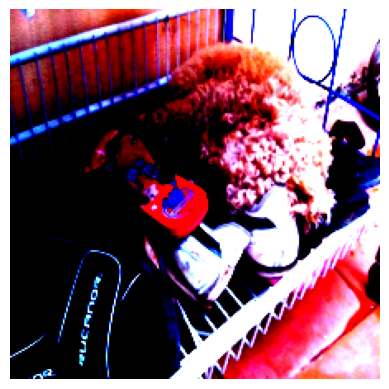

{'index': 0, 'k': 10, 'score': 1.297984683610397e-231, 'true_captions': ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them'], 'predicted_captions': ['A man that is standing in the dirt near a plate.', 'A man standing outside on the grass at night making body motions.', 'An oriental style room with tatami floor coverings.', 'Small bird sitting on a skateboard posed in front of dark blue background cloth.', 'A table with a few vases on it with flowers.']}
---------------------------------------------------------


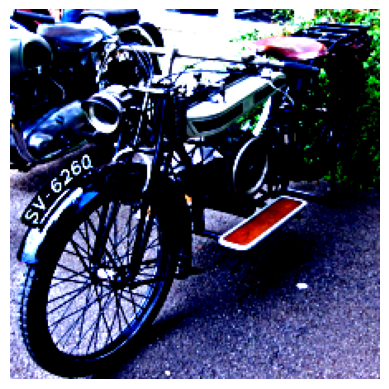

{'index': 1, 'k': 10, 'score': 1.341424715804345e-231, 'true_captions': ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view of a motorized bicycle, sitting in a rack. ', 'The back tire of an old style motorcycle is resting in a metal stand. '], 'predicted_captions': ['A man that is standing in the dirt near a plate.', 'A man standing outside on the grass at night making body motions.', 'An oriental style room with tatami floor coverings.', 'Small bird sitting on a skateboard posed in front of dark blue background cloth.', 'A table with a few vases on it with flowers.']}
---------------------------------------------------------


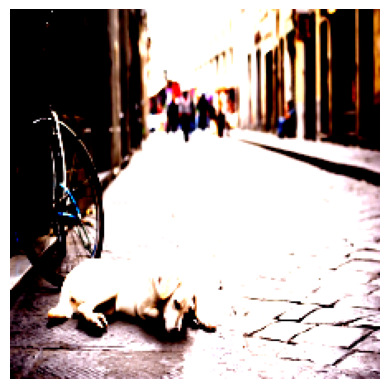

{'index': 2, 'k': 10, 'score': 1.3059638280377332e-231, 'true_captions': ['A picture of a dog laying on the ground.', 'Dog snoozing by a bike on the edge of a cobblestone street', 'The white dog lays next to the bicycle on the sidewalk.', 'a white dog is sleeping on a street and a bicycle', 'A puppy rests on the street next to a bicycle.'], 'predicted_captions': ['A man that is standing in the dirt near a plate.', 'A man standing outside on the grass at night making body motions.', 'An oriental style room with tatami floor coverings.', 'Small bird sitting on a skateboard posed in front of dark blue background cloth.', 'A table with a few vases on it with flowers.']}
---------------------------------------------------------


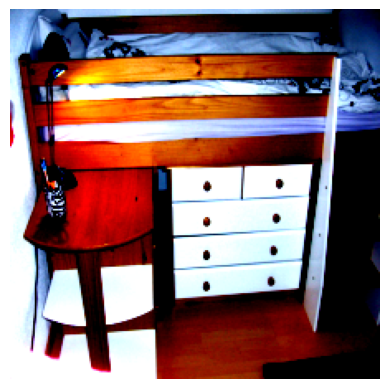

{'index': 3, 'k': 10, 'score': 1.2881612661922353e-231, 'true_captions': ['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. '], 'predicted_captions': ['A man that is standing in the dirt near a plate.', 'A man standing outside on the grass at night making body motions.', 'An oriental style room with tatami floor coverings.', 'Small bird sitting on a skateboard posed in front of dark blue background cloth.', 'A table with a few vases on it with flowers.']}
---------------------------------------------------------


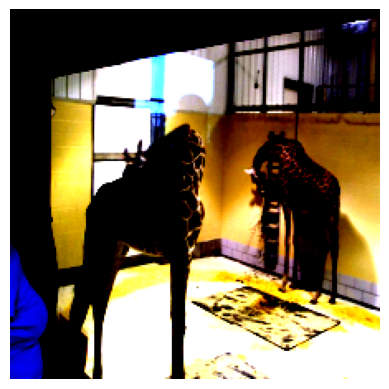

{'index': 4, 'k': 10, 'score': 1.301645287459529e-231, 'true_captions': ['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people'], 'predicted_captions': ['A man that is standing in the dirt near a plate.', 'A man standing outside on the grass at night making body motions.', 'An oriental style room with tatami floor coverings.', 'Small bird sitting on a skateboard posed in front of dark blue background cloth.', 'A table with a few vases on it with flowers.']}
---------------------------------------------------------
Total time taken: 1.7623345851898193 seconds


In [33]:
indexfactory = 'IndexLSH'
caption_generator = FaissCaption(image_embeddings,caption_embeddings,captions_flat,indexfactory= indexfactory)
start_time = time.time()
for i in range(5):

  iq = image_embeddings[i:i+1]
  k=10
  score,pred_caption,real_caption = caption_generator.predict(iq,k,i)
  img, target = coco_dset[i]
  img = img.numpy().transpose(1,2,0)

  d= {
          'index' : i,
          'k' : k,
          'score' : score,
          'true_captions' : real_caption,
          'predicted_captions' : pred_caption
      }

  plt.imshow(img)
  plt.axis('off')  # Turn off axis labels
  plt.show()
  print(d)
  print("---------------------------------------------------------")
end_time = time.time()
total_time = end_time - start_time
print("Total time taken:", total_time, "seconds")

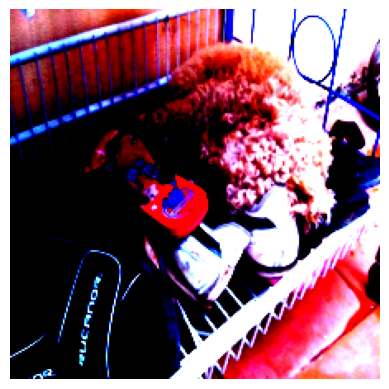

{'index': 0, 'k': 10, 'score': 1.4430261835549853e-231, 'true_captions': ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them'], 'predicted_captions': ['A dog that is sitting on a bed.', 'A dog is laying down on a bed.', 'A dog is laying down on a bed. ', 'A dog that is laying on a bed.', 'A dog that is laying on a bed.']}
---------------------------------------------------------


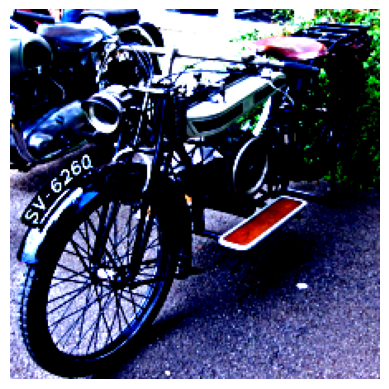

{'index': 1, 'k': 10, 'score': 1.3753195432312128e-231, 'true_captions': ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view of a motorized bicycle, sitting in a rack. ', 'The back tire of an old style motorcycle is resting in a metal stand. '], 'predicted_captions': ['A couple of parked motorcycles near a group of people.', 'a motorcycle parked near other bikes and people near by', 'Several motorcycles that are parked next to each other.', 'A couple of motorcycles are parked as people observe. ', 'several motorcycles are parked next to each other']}
---------------------------------------------------------


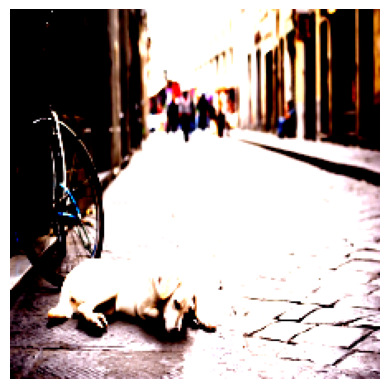

{'index': 2, 'k': 10, 'score': 1.4291802211536658e-231, 'true_captions': ['A picture of a dog laying on the ground.', 'Dog snoozing by a bike on the edge of a cobblestone street', 'The white dog lays next to the bicycle on the sidewalk.', 'a white dog is sleeping on a street and a bicycle', 'A puppy rests on the street next to a bicycle.'], 'predicted_captions': ['A dog is sitting next to a bench. ', 'A dog is sitting near a bench alone.', 'A person sitting on a bench next to a dog.', 'A dog on a leash sitting next to a bench', 'A dog standing on a bench during the day.']}
---------------------------------------------------------


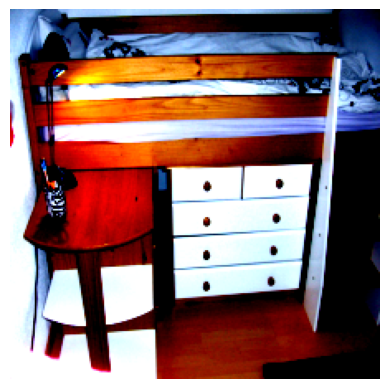

{'index': 3, 'k': 10, 'score': 1.3308896300609707e-231, 'true_captions': ['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. '], 'predicted_captions': ['A bedroom with a bed, desk and shelving unit. ', 'A room with several shelves, several books, a dresser, a couch and a table in it. ', 'A bed, desk and various installations in a room.', 'a cluttered room with a table and shelf on the wall.', 'A bed and desk in a small room.']}
---------------------------------------------------------


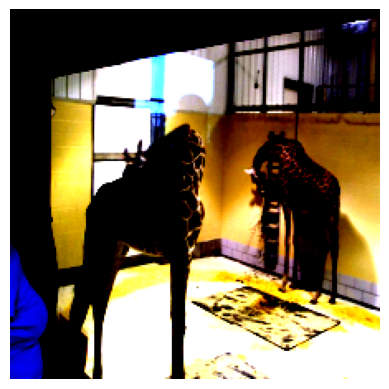

{'index': 4, 'k': 10, 'score': 1.3548071331173708e-231, 'true_captions': ['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people'], 'predicted_captions': ['The two  giraffes are standing close together.', 'there is a group of three giraffes standing together.', 'The two giraffes are standing next to each other. ', 'Two giraffes that are together in an enclosure. ', 'The two giraffes are standing rather closely together. ']}
---------------------------------------------------------
Total time taken: 1.0359811782836914 seconds


In [35]:
indexfactory = 'IndexHNSWFlat'
caption_generator = FaissCaption(image_embeddings,caption_embeddings,captions_flat,indexfactory= indexfactory)
start_time = time.time()
for i in range(5):

  iq = image_embeddings[i:i+1]
  k=10
  score,pred_caption,real_caption = caption_generator.predict(iq,k,i)
  img, target = coco_dset[i]
  img = img.numpy().transpose(1,2,0)

  d= {
          'index' : i,
          'k' : k,
          'score' : score,
          'true_captions' : real_caption,
          'predicted_captions' : pred_caption
      }

  plt.imshow(img)
  plt.axis('off')  # Turn off axis labels
  plt.show()
  print(d)
  print("---------------------------------------------------------")
end_time = time.time()
total_time = end_time - start_time
print("Total time taken:", total_time, "seconds")

We see that IndexHNSWFlat is faster and gave slightly better blew score.

### Qualitative study: Visualize five images, their ground truth captions and the predicted caption.


**Test for k =10**

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

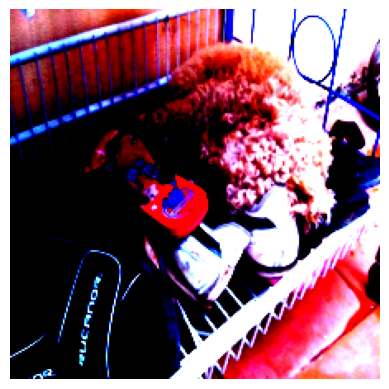

{'index': 0, 'k': 10, 'score': 1.4430261835549853e-231, 'true_captions': ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them'], 'predicted_captions': ['A dog that is sitting on a bed.', 'A dog is laying down on a bed.', 'A dog is laying down on a bed. ', 'A dog that is laying on a bed.', 'A dog that is laying on a bed.']}
---------------------------------------------------------


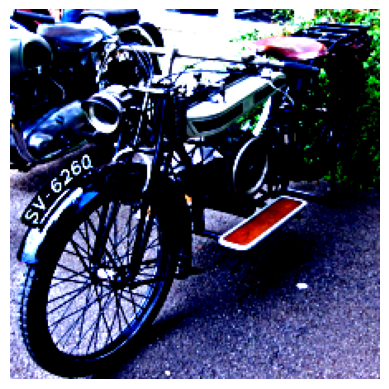

{'index': 1, 'k': 10, 'score': 1.3698151727838202e-231, 'true_captions': ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view of a motorized bicycle, sitting in a rack. ', 'The back tire of an old style motorcycle is resting in a metal stand. '], 'predicted_captions': ['A couple of parked motorcycles near a group of people.', 'a motorcycle parked near other bikes and people near by', 'A motorcycle parked among a group of motorcycles', 'Several motorcycles that are parked next to each other.', 'A couple of motorcycles are parked as people observe. ']}
---------------------------------------------------------


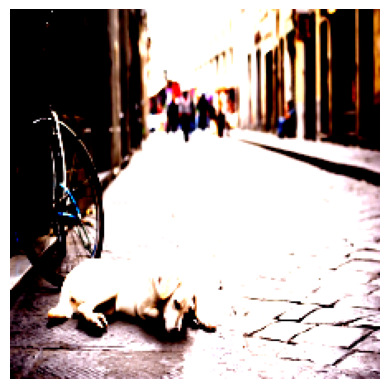

{'index': 2, 'k': 10, 'score': 1.4291802211536658e-231, 'true_captions': ['A picture of a dog laying on the ground.', 'Dog snoozing by a bike on the edge of a cobblestone street', 'The white dog lays next to the bicycle on the sidewalk.', 'a white dog is sleeping on a street and a bicycle', 'A puppy rests on the street next to a bicycle.'], 'predicted_captions': ['A dog is sitting next to a bench. ', 'A dog is sitting near a bench alone.', 'A person sitting on a bench next to a dog.', 'A dog on a leash sitting next to a bench', 'A dog standing on a bench during the day.']}
---------------------------------------------------------


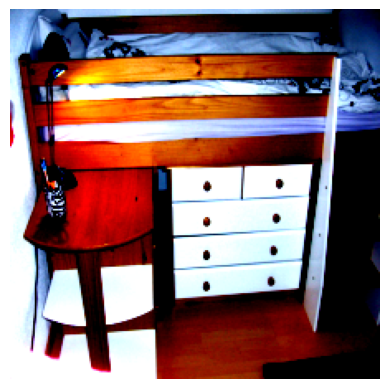

{'index': 3, 'k': 10, 'score': 1.3308896300609707e-231, 'true_captions': ['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. '], 'predicted_captions': ['A bedroom with a bed, desk and shelving unit. ', 'A room with several shelves, several books, a dresser, a couch and a table in it. ', 'A bed, desk and various installations in a room.', 'a cluttered room with a table and shelf on the wall.', 'A bed and desk in a small room.']}
---------------------------------------------------------


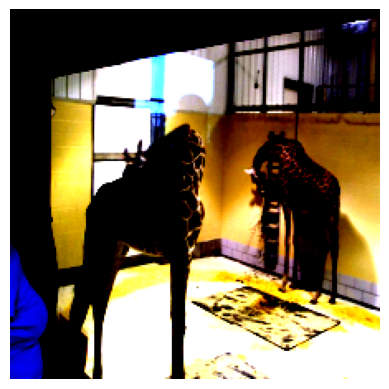

{'index': 4, 'k': 10, 'score': 1.3548071331173708e-231, 'true_captions': ['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people'], 'predicted_captions': ['The two  giraffes are standing close together.', 'there is a group of three giraffes standing together.', 'The two giraffes are standing next to each other. ', 'Two giraffes that are together in an enclosure. ', 'The two giraffes are standing rather closely together. ']}
---------------------------------------------------------


In [29]:
caption_generator = FaissCaption(image_embeddings,caption_embeddings,captions_flat)
for i in range(5):

  iq = image_embeddings[i:i+1]
  k=10
  score,pred_caption,real_caption = caption_generator.predict(iq,k,i)
  img, target = coco_dset[i]
  img = img.numpy().transpose(1,2,0)

  d= {
          'index' : i,
          'k' : k,
          'score' : score,
          'true_captions' : real_caption,
          'predicted_captions' : pred_caption
      }

  plt.imshow(img)
  plt.axis('off')  # Turn off axis labels
  plt.show()
  print(d)
  print("---------------------------------------------------------")

Test for k =4 (best bleu score)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

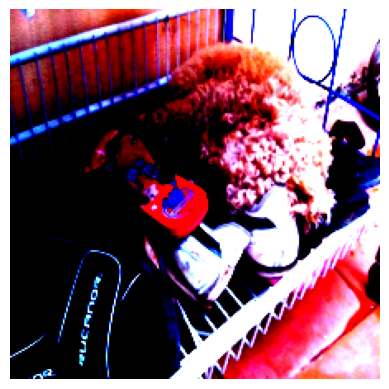

{'index': 0, 'k': 4, 'score': 1.395188507406114e-231, 'true_captions': ['This wire metal rack holds several pairs of shoes and sandals', 'A dog sleeping on a show rack in the shoes.', 'Various slides and other footwear rest in a metal basket outdoors.', 'A small dog is curled up on top of the shoes', 'a shoe rack with some shoes and a dog sleeping on them'], 'predicted_captions': ['Two dogs sitting on a bed sleeping on a bed.', 'Two dogs are laying on a bed together.', 'two dogs are laying in a bed together', 'Two dogs laying down on a bed together. ', 'a couple of dogs are laying on a bed together']}
---------------------------------------------------------


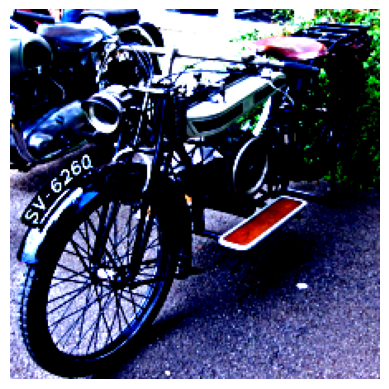

{'index': 1, 'k': 4, 'score': 1.3806872809833178e-231, 'true_captions': ['A motorcycle parked in a parking space next to another motorcycle.', 'An old motorcycle parked beside other motorcycles with a brown leather seat.', 'Motorcycle parked in the parking lot of asphalt.', 'A close up view of a motorized bicycle, sitting in a rack. ', 'The back tire of an old style motorcycle is resting in a metal stand. '], 'predicted_captions': ['A motorcycle on display near people standing around and talking.', ' A motorcycle parked in front of a crowd of people.', 'a motorcycle parked near other bikes and people near by', 'A motorcycle parked on the grass with people in back.', 'A motorcycle is parked on the grass while people look']}
---------------------------------------------------------


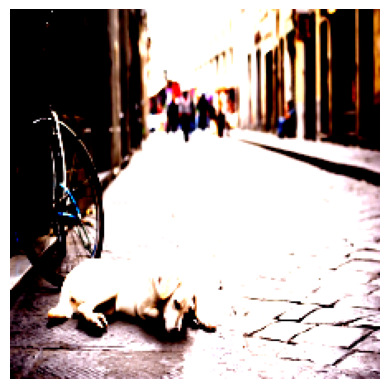

{'index': 2, 'k': 4, 'score': 1.443876201869816e-231, 'true_captions': ['A picture of a dog laying on the ground.', 'Dog snoozing by a bike on the edge of a cobblestone street', 'The white dog lays next to the bicycle on the sidewalk.', 'a white dog is sleeping on a street and a bicycle', 'A puppy rests on the street next to a bicycle.'], 'predicted_captions': ['A dog is on the ground near people and a bike.', 'A brown dog is laying by a bench.', 'A dog is sitting near a bench alone.', 'A dog on a leash sitting next to a bench', 'A dog is sitting next to a bench. ']}
---------------------------------------------------------


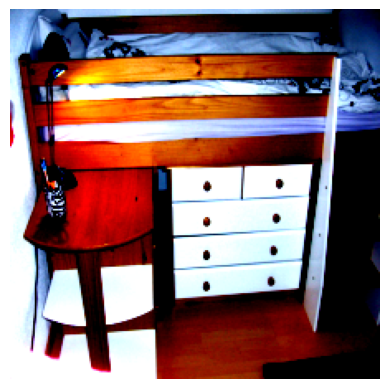

{'index': 3, 'k': 4, 'score': 1.2811996063470272e-231, 'true_captions': ['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. '], 'predicted_captions': ['A small kitchen cluttered with a variety of kitchen items.', 'A kitchen with drawers and an oven, and items on the counter.', 'A kitchen counter with appliance and utensils all around. ', 'A kitchen is shown with things on the counters.', 'a kitchen with a stove and counter tops and shelves filled with food.']}
---------------------------------------------------------


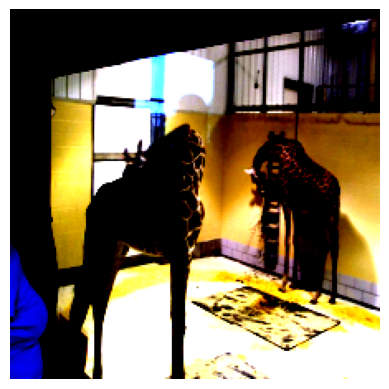

{'index': 4, 'k': 4, 'score': 1.364715935515638e-231, 'true_captions': ['Two giraffes in a room with people looking at them.', 'Two giraffe standing next to each other in a room.', 'The giraffe is being kept by itself indoors. ', 'A man and woman staring at two giraffes through a window.', 'a giraffe in a enclosed area is watched by some people'], 'predicted_captions': ['The two  giraffes are standing close together.', 'The two giraffes are standing next to each other. ', 'Two giraffes standing next to each other in an enclosure.', 'there is a group of three giraffes standing together.', 'The two giraffes are standing rather closely together. ']}
---------------------------------------------------------


In [30]:
caption_generator = FaissCaption(image_embeddings,caption_embeddings,captions_flat)
for i in range(5):
  k =4
  iq = image_embeddings[i:i+1]
  score,pred_caption,real_caption = caption_generator.predict(iq,k,i)
  img, target = coco_dset[i]
  img = img.numpy().transpose(1,2,0)

  d= {
          'index' : i,
          'k' : k,
          'score' : score,
          'true_captions' : real_caption,
          'predicted_captions' : pred_caption
      }

  plt.imshow(img)
  plt.axis('off')  # Turn off axis labels
  plt.show()
  print(d)
  print("---------------------------------------------------------")